#ERD


   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5 

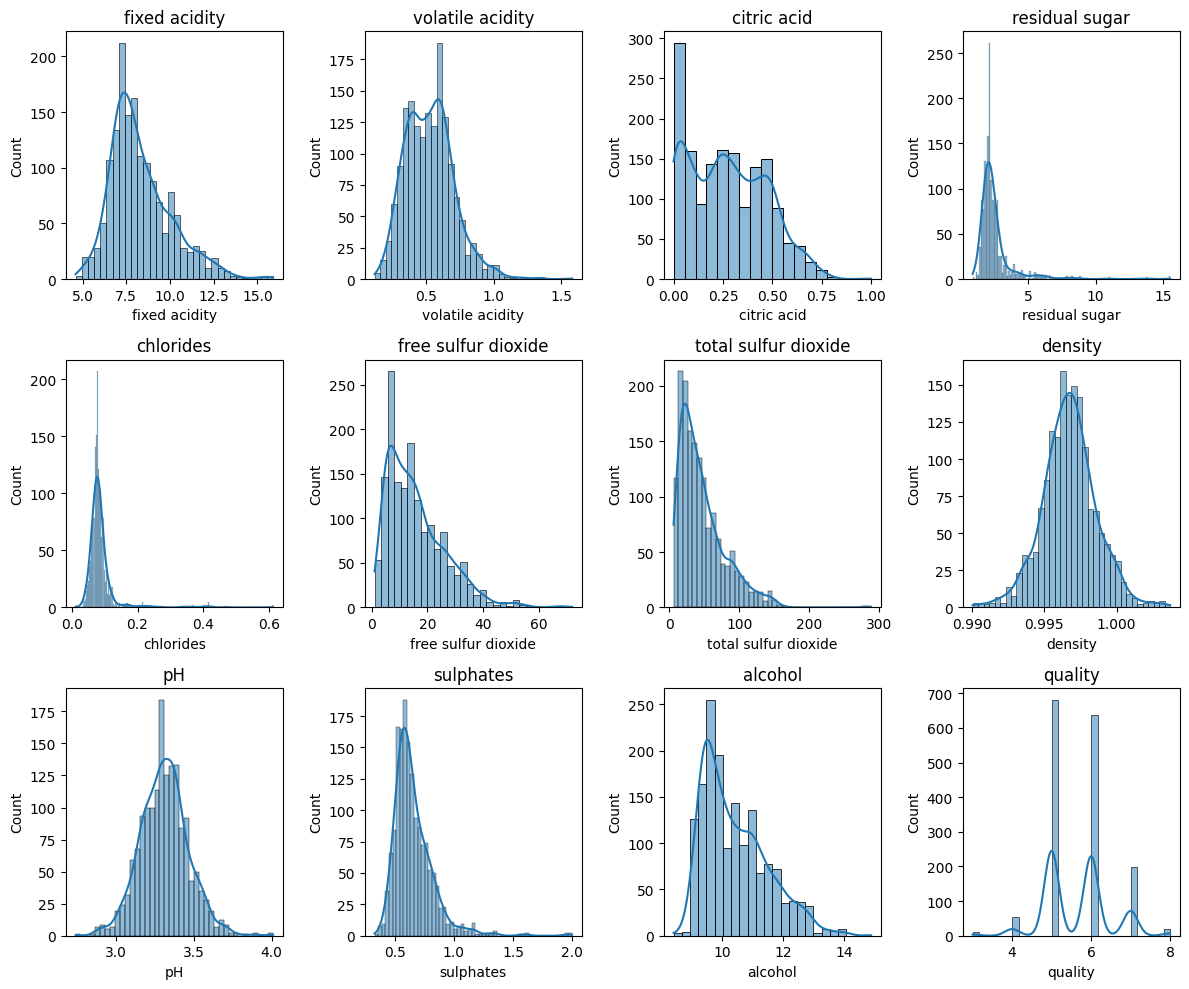

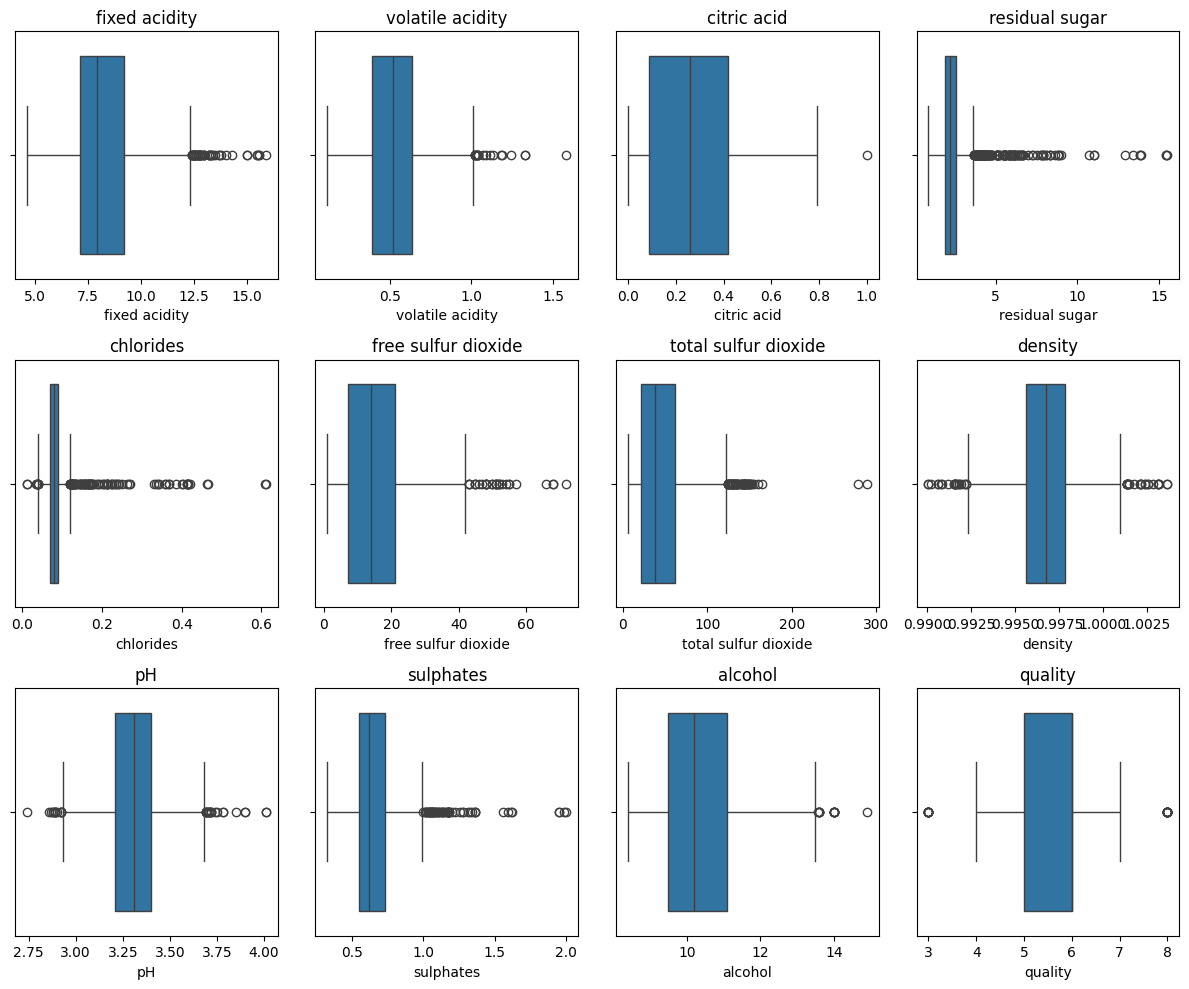

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 불러오기
data = pd.read_csv('winequality-red.csv')

# 데이터 확인
print(data.head())

# 각 column의 데이터 타입 및 결측치 확인
print(data.info())

# 각 column의 기술통계량 확인
print(data.describe())

# 각 column의 분포 시각화
plt.figure(figsize=(12, 10))
for i, col in enumerate(data.columns):
    plt.subplot(3, 4, i + 1)
    sns.histplot(data[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

# 이상치 확인 (boxplot으로 확인)
plt.figure(figsize=(12, 10))
for i, col in enumerate(data.columns):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(x=data[col])
    plt.title(col)
plt.tight_layout()
plt.show()


#전처리

In [44]:
# 결측치 확인 및 처리
print(data.isnull().sum())

# Z-score 이용한 이상치 제거
from scipy.stats import zscore

z_scores = zscore(data)
abs_z_scores = abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
data = data[filtered_entries]

# Min-Max 데이터 스케일링
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


#요인 분석

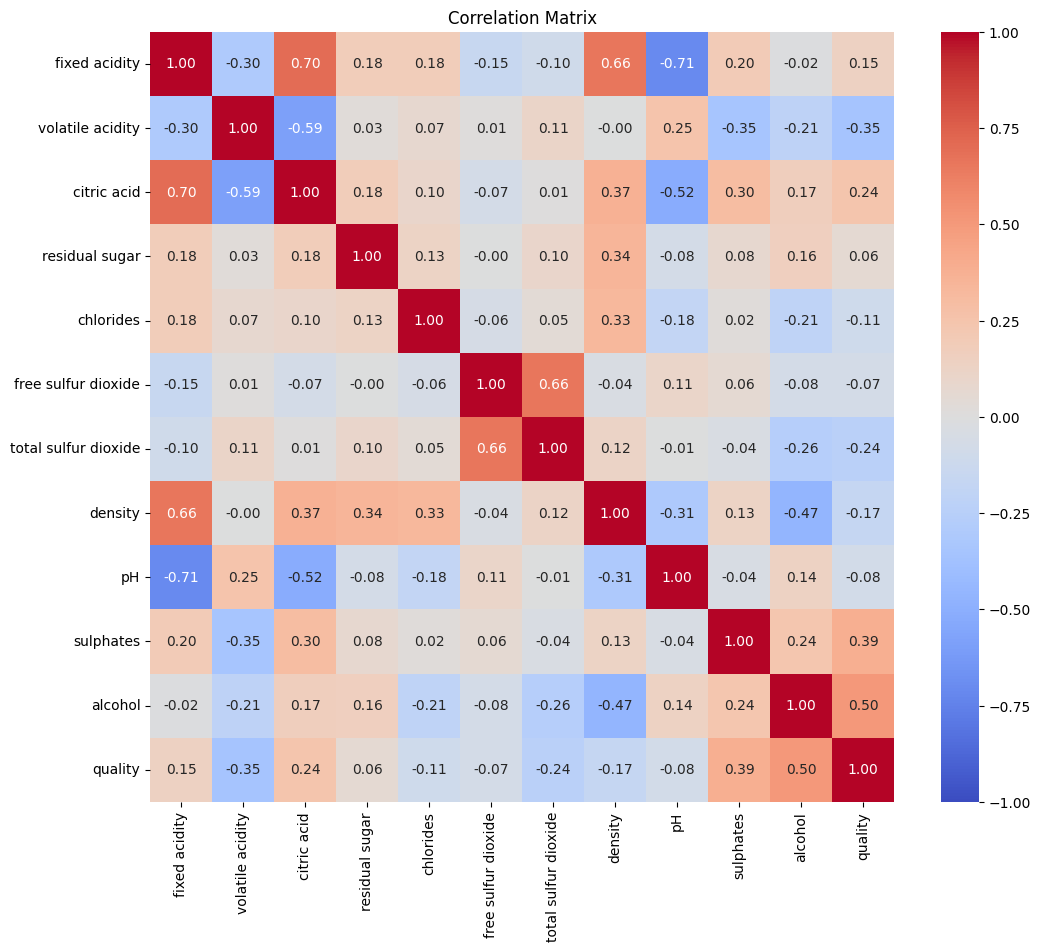

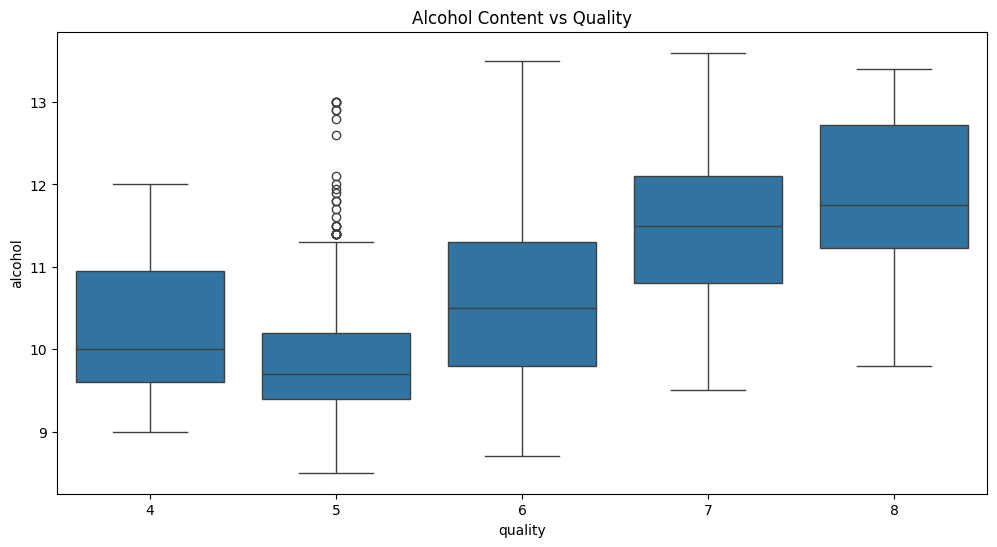

In [45]:
# 상관 분석
correlation_matrix = data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

# 품질과 다른 변수들 간의 관계 시각화 (예시)
plt.figure(figsize=(12, 6))
sns.boxplot(x='quality', y='alcohol', data=data)
plt.title('Alcohol Content vs Quality')
plt.show()


#품질 예측 모델 구축

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score

# 데이터 준비
X = data.drop('quality', axis=1)
y = data['quality']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#모델 학습

In [48]:
from sklearn.metrics import roc_auc_score
from itertools import combinations

# 모든 컬럼의 부분집합 생성
all_columns = X.columns
all_subsets = []

for i in range(1, len(all_columns) + 1):
    subsets_i = list(combinations(all_columns, i))
    all_subsets.extend(subsets_i)

# 모델 평가를 위한 함수 정의
def evaluate_model_auc(subset, X_train, X_test, y_train, y_test):
    # 모델 선택 (예시로 랜덤 포레스트 분류 모델 사용)
    model = RandomForestClassifier(random_state=42)

    # 선택된 변수들로 데이터셋 재구성
    X_train_subset = X_train[list(subset)]
    X_test_subset = X_test[list(subset)]

    # 모델 학습
    model.fit(X_train_subset, y_train)

    # 예측 확률 계산
    y_pred_proba = model.predict_proba(X_test_subset)

    # AUC 계산
    auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovo')

    return auc

# 각 부분집합에 대해 AUC 계산
results = []
for subset in all_subsets:
    auc = evaluate_model_auc(subset, X_train, X_test, y_train, y_test)
    results.append((subset, auc))

#모델 평가

In [47]:
# 결과를 AUC 기준으로 정렬
sorted_results = sorted(results, key=lambda x: x[1], reverse=True)

# 상위 10개 부분집합에 대한 결과 출력
for subset, auc in sorted_results[:10]:
    print(f"Subset: {subset}")
    print(f"AUC: {auc:.4f}")
    print()

Subset: ('volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'sulphates', 'alcohol')
AUC: 0.8531

Subset: ('volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'density', 'sulphates', 'alcohol')
AUC: 0.8526

Subset: ('volatile acidity', 'residual sugar', 'free sulfur dioxide', 'density', 'pH', 'sulphates')
AUC: 0.8495

Subset: ('citric acid', 'residual sugar', 'chlorides', 'total sulfur dioxide', 'density', 'sulphates', 'alcohol')
AUC: 0.8492

Subset: ('fixed acidity', 'residual sugar', 'chlorides', 'total sulfur dioxide', 'pH', 'sulphates', 'alcohol')
AUC: 0.8479

Subset: ('volatile acidity', 'residual sugar', 'free sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol')
AUC: 0.8479

Subset: ('fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'total sulfur dioxide', 'density', 'sulphates', 'alcohol')
AUC: 0.8472

Subset: ('citric acid', 'residual sugar', 'chlorides', 'total sulfur dioxide', 'pH', 'sulphates', 'alco

#결과 해석
Subset: ('volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'sulphates', 'alcohol')
일 때 AUC의 값이 가장 높게 나왔으며,

상위 10개의 결과를 살펴 볼 때, 가장 많이 등장한 변수 'residual sugar', 'volatile acidity', 'sulphates', 'alcohol' 에 따라 와인의 품질이 크게 좌우하는 것을 알 수 있다.